In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
ls

drive/  sample_data/


In [3]:
cd drive/MyDrive/Dataset/


/content/drive/MyDrive/Dataset


In [65]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import euclidean_distances


**Dataset Information :**

- cluster originally empty
- unique id for each data point
- x point x-coordinate
- y point y-coordinate
- num neighbors number of neighbors,
- List of neighbors to the coordinates above neighbors the id&#39;s of all neighbors within

**Sample Data :**

| cluster | pt | x | y | num\_neighbors | neighbors |
| --- | --- | --- | --- | --- | --- |
|
 | 0 | 51.41808903 | 13.59361029 | 2 | 0,27 |
|
 | 1 | 39.1323184 | -4.419204415 | 3 | 1,40,75 |
|
 | 2 | 47.8075151 | -25.82256055 | 1 | 2 |
|
 | 3 | 27.69970293 | 53.43419307 | 1 | 3 |
|
 | 4 | 39.86099482 | 5.676870902 | 3 | 4,56,75 |
|
 | 5 | -19.89185932 | 10.41027381 | 3 | 5,70,74 |

In [158]:
def loadFile(filename):
  neighList = []
  pointList = []
  #  load data frame
  df = pd.read_csv(filename)
  
  # load x and y into points list

  points = df[["x", "y"]]
  
  # preprocess neighbors
  df["neighbors"] = [[int(_neigh) for _neigh in neigh_list.split(",")] for neigh_list in df["neighbors"]]
  
  # get list of neigh count and list of neigh to point

  neighs = df[["num_neighbors","neighbors"]]

  pointsList = points.to_numpy(dtype=float)
  neighsList = neighs.to_numpy(dtype=list)
  
  npArray = df.to_numpy()

  return pointsList.tolist(), neighsList.tolist(), npArray



In [5]:
def runDBScan(pointList, neighList, MinPts, epsilon):

  clusters=[]
  index = 0
  visited = set()
  noiseList = []
  # iterate over all the points until all the points assigned to cluster
  for i in range(len(pointList)) :
    # check if it is not visited
    if i not in visited:
      visited.add(i)
      # check if number of neighbours to this points greater or equals to min_pts or not
      numberOfneighs = neighList[i][0]
      neighbours = neighList[i][1]

      if numberOfneighs >= MinPts:
        # not a noise point
        # form a cluster by appending it into clusters
        clusters.append([])
        # append this points
        clusters[index].append(i)
        # form a cluster using information of neighbourhood
        createCluster(visited, neighbours, index,i,  epsilon, neighList,pointList, MinPts,clusters)
        # all the points that can be in this point's clusters are done
        #  increment index we will form new cluster now
        index+=1
      else:
        # noisy point add in noisy point list
        noiseList.append(i)

  # assign noise in seperate cluster
  # noisy cluster
  clusters.append([])
  for noise in noiseList:
    clusters[index].append(noise)

  return clusters


In [12]:
def createCluster (visited, currentNeighbourhood, clusterIndex, currindexPts, epsilon, neighList, pointList, MinPts, clusters) :
  for neighidx in currentNeighbourhood :
    if neighidx not in visited:
      visited.add(neighidx)
      if neighList[neighidx][0] >= MinPts:
        extraNeighbours = neighList[neighidx][1]
        currentNeighbourhood+= extraNeighbours
    #  if point is already in some cluster don't assign
    isAssigned = False
    for cs in clusters:
      if neighidx in cs :
        isAssigned = True
    if isAssigned == False:
      clusters[clusterIndex].append(neighidx)



In [7]:
def getClusterPointsfromIndex(clusters,pointList):
  clusterPoints= []
  index = 0
  for cluster in clusters:
    clusterPoints.append([])
    for idx in cluster:
      clusterPoints[index].append(pointList[idx])
    index+=1
  return clusterPoints
  

In [160]:
def plotClusters(CP, title):
  for _cluster in CP:
    plt.scatter([point[0] for point in _cluster], [point[1] for point in _cluster])
    plt.title(title)
  plt.show()

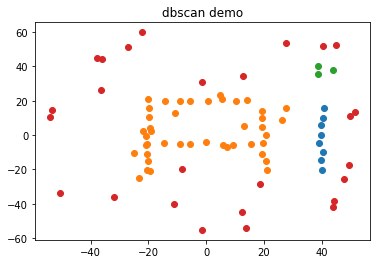

In [161]:
#  load file
pointList, neighList, npArray = loadFile("dbscan.csv")

#  run DBScan to get clusters indexes
clusterIdx = runDBScan(pointList, neighList, 3, 7.5)
# get cluster points form indexes
clusterPoints = getClusterPointsfromIndex(clusterIdx, pointList)
# plot the cluster
plotClusters(clusterPoints,"dbscan demo")

In [108]:
def loadDataset(file):
  data = pd.read_csv(file)
  points = data.to_numpy()
  return points, data
points, data = loadDataset("circle.csv")


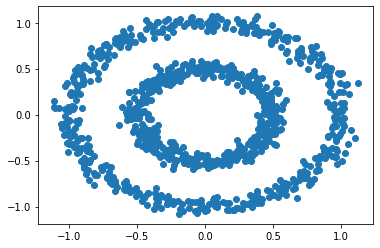

In [109]:
# plot data set
plt.scatter([point[0] for point in points.tolist()], [point[1] for point in points.tolist()])
plt.show()

In [146]:
# get neighbours and neighbourscount
def getNeighbours(points,epsilon , distance='euclidean'):
  neighbourhood = []
  for i in range(len(points)):
    counter = 1
    neighset = set()
    neighset.add(i)
    for j in range(len(points)):
      if i !=  j :
        
        dist = np.sqrt(np.dot(points[i], points[i]) - 2 * np.dot(points[i], points[j]) + np.dot(points[j], points[j]))
        if (dist <= epsilon):
          counter += 1
          neighset.add(j)
          # ",".join(a_list)
    converted_list = [str(element) for element in list(neighset)]
    neighbourhood.append([counter,",".join(converted_list)])
  return neighbourhood



# neighbourHood = getNeighbours(points, .05)


In [77]:

# data["num_neighbors"] = neighbourHood

In [147]:
def generateDataSet(points, data, epsilon, filename):
  neighbourHood = getNeighbours(points, epsilon)
  neighborsDataFrame = pd.DataFrame(neighbourHood, columns=['num_neighbors','neighbors'])
  ptsSeries = pd.Series([i for i in range(len(neighbourHood))])
  cluster = pd.Series(["" for i in range(len(neighbourHood))])
  dataset = pd.DataFrame()
  data["pt"] = ptsSeries
  data["cluster"] = cluster
  data["num_neighbors"] = neighborsDataFrame["num_neighbors"]
  data["neighbors"] = neighborsDataFrame["neighbors"]
  data.columns = ["x","y","pt","cluster","num_neighbors","neighbors"]
  data.to_csv(filename, index=False)
  return data


#Circle Data Set Experiment:

In [ ]:
# db scan on Circle data set
EpsilonList = [0.02,0.05,0.1,0.5,1]
minPts = [1,2,3,4,5]
for min_pts in minPts:
  for epsilon in EpsilonList:

    circleDataset = generateDataSet(points, data, epsilon,"processedCircle.csv")

    #  load file
    circlePoints, circleNeighList, numpyData = loadFile("processedCircle.csv")

    #  run DBScan to get clusters indexes
    circleClusterIdx = runDBScan(circlePoints, circleNeighList, min_pts, epsilon)
    # get cluster points form indexes
    circleClusterPoints = getClusterPointsfromIndex(circleClusterIdx, circlePoints)
    # plot the cluster
    plotClusters(circleClusterPoints, f"Circle Dataset  min_pts :{ min_pts}, epsilon : {epsilon}")

#Blob Data Set Experiment:

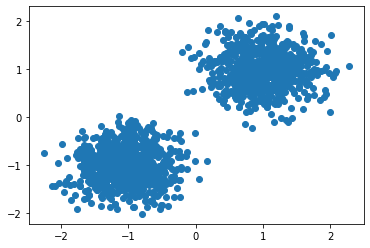

In [164]:
blobpoints, blobdata = loadDataset("blobs.csv")
# plot row blob data points to look into data set
# plot data set
plt.scatter([point[0] for point in blobpoints.tolist()], [point[1] for point in blobpoints.tolist()])
plt.show()

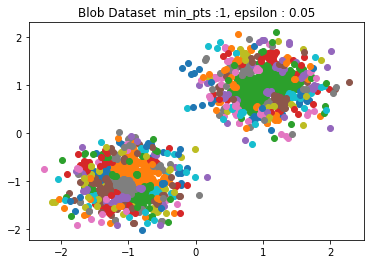

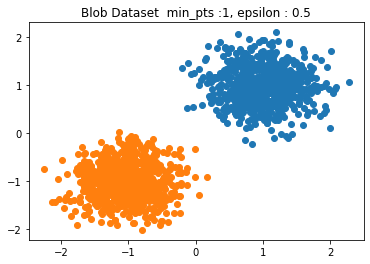

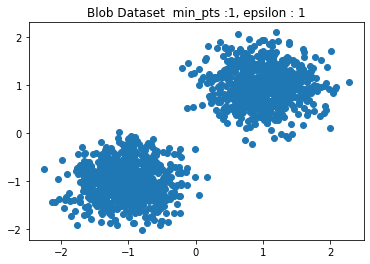

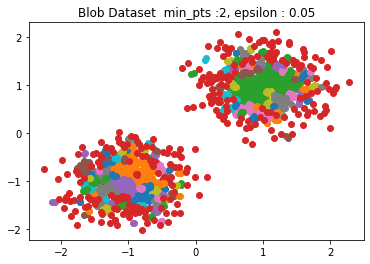

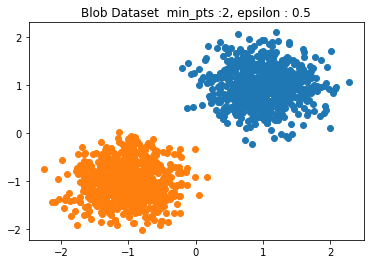

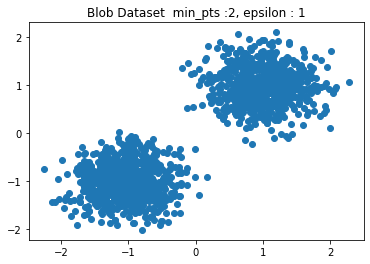

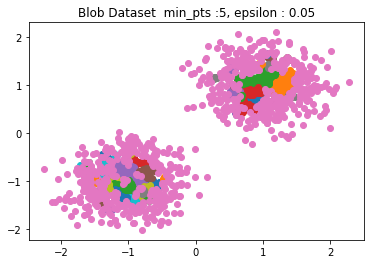

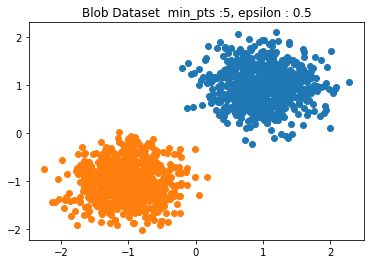

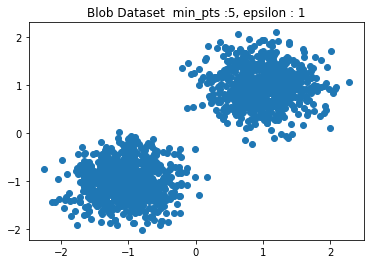

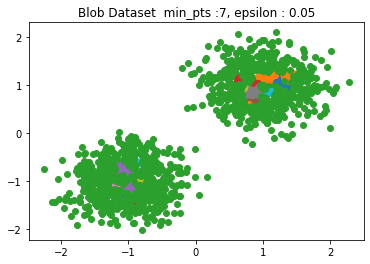

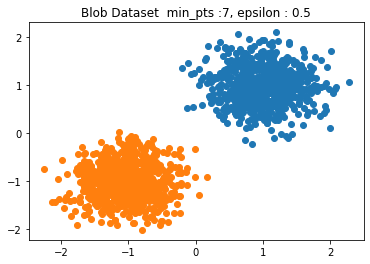

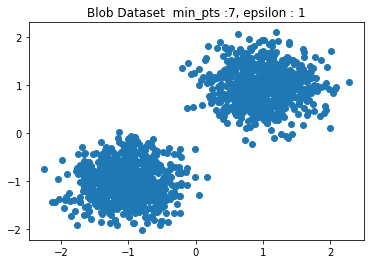

In [166]:
# db scan on Blob data set
EpsilonList = [0.05,0.5,1]
minPts = [1,2,5,7]
for min_pts in minPts:
  for epsilon in EpsilonList:

    blobDataset = generateDataSet(blobpoints, blobdata, epsilon,"processedBlob.csv")

    #  load file
    blobPoints, blobNeighList, numpyData = loadFile("processedBlob.csv")

    #  run DBScan to get clusters indexes
    blobClusterIdx = runDBScan(blobPoints, blobNeighList, min_pts, epsilon)
    # get cluster points form indexes
    blobClusterPoints = getClusterPointsfromIndex(blobClusterIdx, blobPoints)
    # plot the cluster
    plotClusters(blobClusterPoints, f"Blob Dataset  min_pts :{ min_pts}, epsilon : {epsilon}")